#### Entropy
Like entropy.ipynb, but source is now the gene set, and target is the L100 gene set

In [38]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [39]:
def getGS(fname):
    df = pd.read_csv(fname, delimiter='_', header=None)
    df['gs'] = df.loc[:,2].str.replace('^\d+\t\t','').str.split('\t')
    df.drop([0,1,2], inplace=True, axis=1)
    return df.copy()

df_assoc = getGS('../out/20.0216 feat/reg_univariate_rf/network/gs.txt') #get the reg univariate-rf results
df_infer = getGS('../out/20.0216 feat/reg_rf_boruta/network/gs.txt') #get the rf-boruta results

# L100 results
df_L100 = pd.read_csv('../out/19.1013 tight cluster/landmarks_n100_k100.csv')

In [12]:
df_assoc['gs_size'] = df_assoc.apply(lambda x: len(x[0]), axis=1)
df_infer['gs_size'] = df_infer.apply(lambda x: len(x[0]), axis=1)

In [13]:
df_assoc.head()

,gs,gs_size
0,"[FASN, ACACA, CHP1, GOLGA8EP, GPAT4, GOLGA8CP,...",103
1,"[ACLY, ACSS1, TFRC, MTHFD1, LCA5, AP2M1, PAICS...",117
2,"[SCD, ACSL1, ACSL3, C12orf49, MIR137HG, AC0087...",80
3,"[IL16, SLC37A3, USP22, ATXN7L3, ENY2, SUPT20H,...",82
4,"[SOD2, POP5, AK6, PARN, EXOSC10, NOL6, TAMM41,...",167


In [14]:
# retrieve the genes L100
df_L100['gs'] = df_L100.genes.apply(lambda x: re.findall('(\w*)\.\.', x))
df_L100['gs'] = df_L100.apply(lambda x: re.findall('(\w*)\s', x['landmark'])+x['gs'], axis=1)
df_L100['gs_size'] = df_L100.apply(lambda x: len(x['gs']), axis=1)
df_L100.head()

,cluster,genes,size,landmark,gs,gs_size
0,1,"ABHD8..79575.,ACP5..54.,ACTL9..284382.,ADAMTS1...",224,TMEM167A (153339),"[TMEM167A, ABHD8, ACP5, ACTL9, ADAMTS10, AKAP8...",225
1,2,"AADAT..51166.,ABAT..18.,ACTL6B..51412.,ADHFE1....",226,CDC40 (51362),"[CDC40, AADAT, ABAT, ACTL6B, ADHFE1, AEBP2, AF...",227
2,3,"AASS..10157.,ADI1..55256.,ADO..84890.,AES..166...",261,PBRM1 (55193),"[PBRM1, AASS, ADI1, ADO, AES, AGXT, AGXT2, AIM...",262
3,4,"ACTR5..79913.,ADRM1..11047.,AICDA..57379.,ARID...",182,PDS5A (23244),"[PDS5A, ACTR5, ADRM1, AICDA, ARID1B, ARID3C, A...",183
4,5,"ABT1..29777.,ACD..65057.,ACTR8..93973.,AFF1..4...",173,SMARCE1 (6605),"[SMARCE1, ABT1, ACD, ACTR8, AFF1, AFF4, AIP, A...",174


#### calculate multinomial probability, and entropy

In [15]:
from scipy.stats import multinomial

def calcOverlap(df_source, df_target):
    score = 1
    gs_target = df_target['gs']
    gs_target_sizes = df_target['gs_size']
    gs_source = df_source['gs']
    
    overlap_n = []
    for gs in gs_target:
        overlap_n.append( len(set(gs).intersection(set(gs_source))) )

    p = multinomial.pmf(overlap_n, n=sum(overlap_n), p = gs_target_sizes.values/gs_target_sizes.sum() )
    return p

pmfs_assoc = df_assoc.apply(calcOverlap, df_target=df_L100, axis=1)
pmfs_infer = df_infer.apply(calcOverlap, df_target=df_L100, axis=1)

In [32]:
df = pd.DataFrame({'assoc': pmfs_assoc,
                   'infer': pmfs_infer,})

In [33]:
df.describe()

,assoc,infer
count,4.700000e+01,4.000000e+01
mean,1.341450e-04,3.334990e-08
std,9.195982e-04,1.480534e-07
min,3.740258e-157,1.412001e-162
25%,3.002231e-54,8.701890e-64
50%,5.214500e-41,4.048964e-45
75%,8.796155e-18,7.518320e-34
max,6.304456e-03,7.678188e-07


In [37]:
pd.DataFrame([{'assoc':-np.sum(df.assoc* np.log(df.assoc)),
              'infer':-np.sum(df.infer* np.log(df.infer))}], index=['entropy'])

,assoc,infer
entropy,0.031947,0.000019


#### Calculate simply overlap counts

In [20]:
def calcOverlap(df_source, df_target):
    score = 1
    gs_target = df_target['gs']
    gs_target_sizes = df_target['gs_size']
    gs_source = df_source['gs']
    
    overlap_n = []
    for gs in gs_target:
        overlap_n.append( len(set(gs).intersection(set(gs_source))) )
        
    return overlap_n

overlapN_assoc = df_assoc.apply(calcOverlap, df_target=df_L100, axis=1)
overlapN_infer = df_infer.apply(calcOverlap, df_target=df_L100, axis=1)

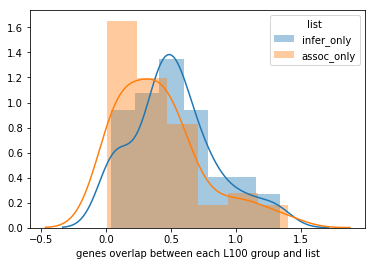

In [21]:
sns.distplot(overlapN_infer.apply(lambda x: np.mean(x)))
sns.distplot(overlapN_assoc.apply(lambda x: np.mean(x)))

plt.legend(title='list',loc='upper right', labels=['infer_only', 'assoc_only'])
plt.xlabel('genes overlap between each L100 group and list')
plt.show()

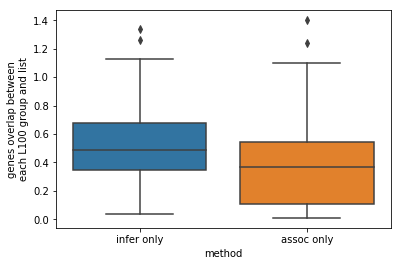

In [22]:
df1 = pd.DataFrame({'val':overlapN_infer.apply(lambda x: np.mean(x)), 'method':'infer only'})
df2 = pd.DataFrame({'val':overlapN_assoc.apply(lambda x: np.mean(x)), 'method':'assoc only'})
df = pd.concat([df1,df2])
sns.boxplot('method', 'val', data = df)
plt.ylabel('genes overlap between\neach L100 group and list')
plt.show()